In [47]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import optuna

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

### 1. Получите данные и загрузите их в рабочую среду. 

In [48]:
current_directory = Path.cwd()
DATA_PATH = current_directory.parent / 'data/glass.csv'

In [49]:
data = pd.read_csv(DATA_PATH)
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### 2. Проведите первичный анализ.

#### (А) Проверьте количество записей для каждого класса. Сделайте вывод.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [51]:
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [52]:
data.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [53]:
data.duplicated().sum()

1

In [54]:
data = data.drop_duplicates()

In [55]:
data.duplicated().sum()

0

In [56]:
data.shape

(213, 10)

- Пропусков нет, поэтому необходимость в их удалении отсутсвует;
- Присутствует один дублированный сэмпл, удаляем.

In [57]:
data['Type'].value_counts()

Type
2    76
1    69
7    29
3    17
5    13
6     9
Name: count, dtype: int64

/tmp/ipykernel_2295/2122689624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Type'], palette='viridis')


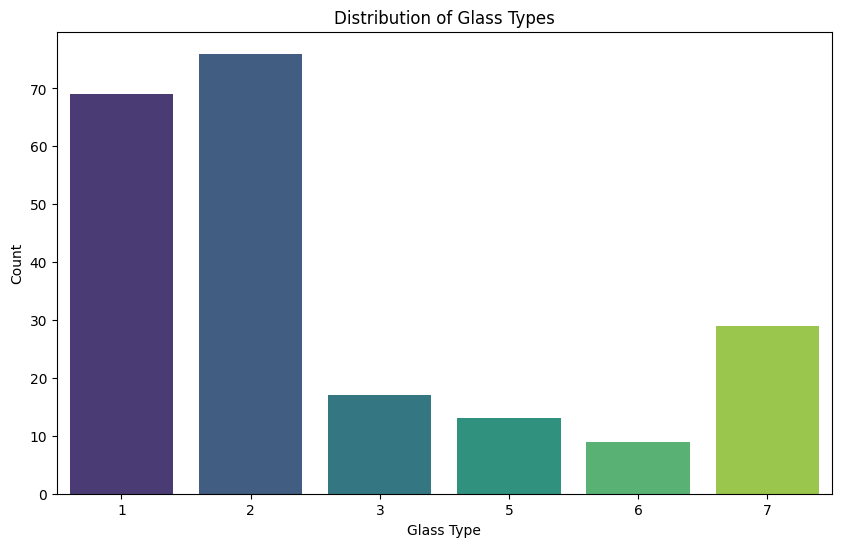

In [58]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['Type'], palette='viridis')
plt.title('Distribution of Glass Types')
plt.xlabel('Glass Type')
plt.ylabel('Count')
plt.show()

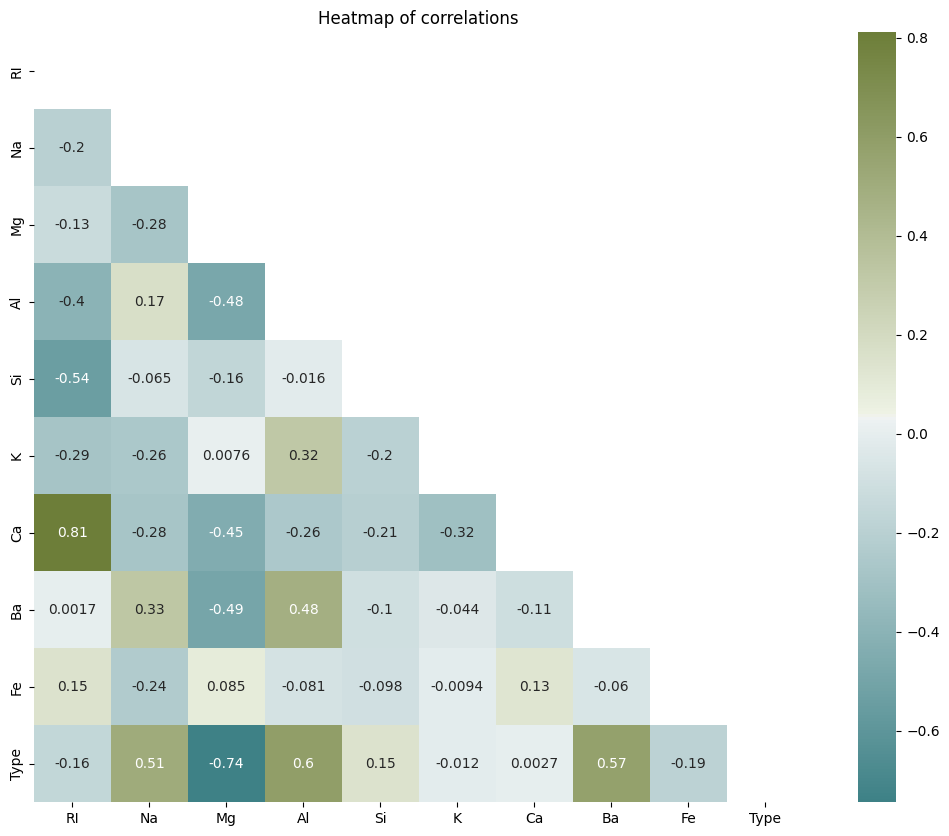

In [59]:
fig, ax = plt.subplots(figsize=(14, 10))
plt.title('Heatmap of correlations')
mask = np.triu(np.ones_like(data.corr(), dtype=float))
cmap = sns.diverging_palette(200, 100, as_cmap=True)
sns.heatmap(data.corr(), mask=mask, cmap=cmap, square=True, annot=True, fmt='.2g')
plt.show()

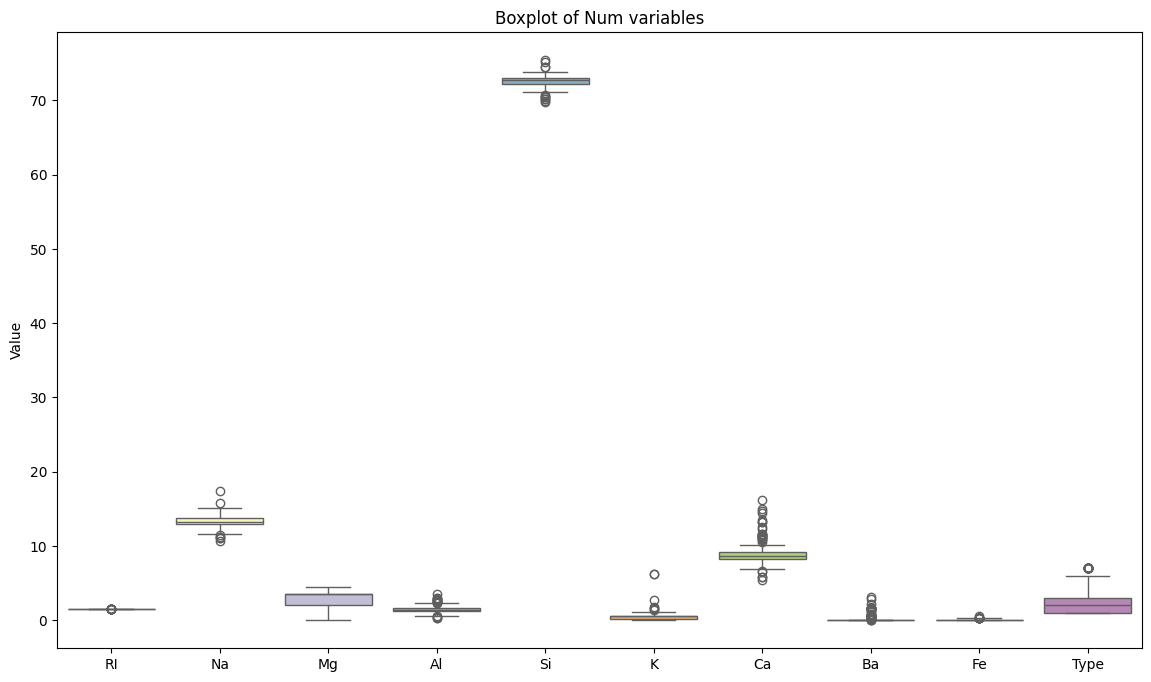

In [60]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=data, palette='Set3')
plt.title('Boxplot of Num variables')
plt.ylabel('Value')
plt.show()

Некоторые признаки имеют выбросы, обработаем их после разделения на трейн и тест выборки.

Определили распределение в данных, чтобы подобрать для каждого свой подход в "стандартизации"/"нормализации"

### 3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.

In [61]:
X = data.drop(columns=['Type'])
y = data['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Обучите модель дерева решений RandomForestClassifier на обучающем множестве.

In [62]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (accuracy).

In [63]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classifier:")
rf_accuracy = accuracy_score(y_test, y_pred_rf) 
print(rf_accuracy)

Random Forest Classifier:
0.7674418604651163


### 6. Обработайте выбросы в данных.

#### (A) Визуализируйте распределение значений для каждой переменной. Можно использовать функции sns.boxplot, sns.distplot. Есть ли признаки с нормальным распределением?

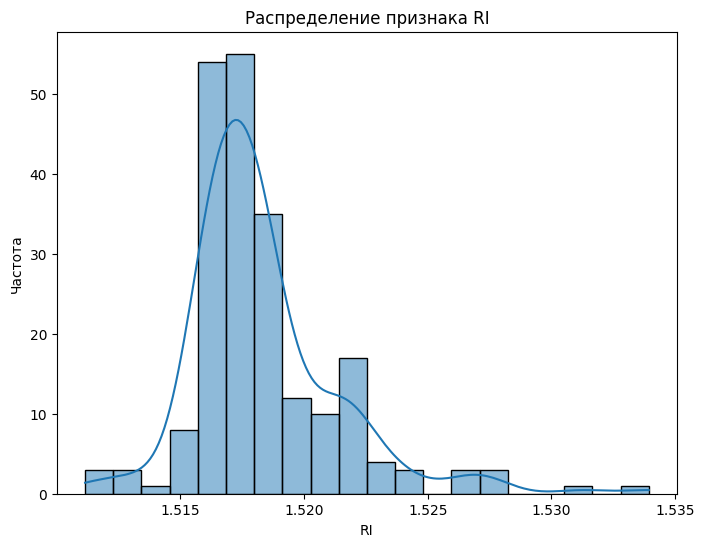

In [64]:
plt.figure(figsize=(8, 6))
sns.histplot(data['RI'], bins=20, kde=True)
plt.title("Распределение признака RI")
plt.xlabel("RI")
plt.ylabel("Частота")
plt.show()

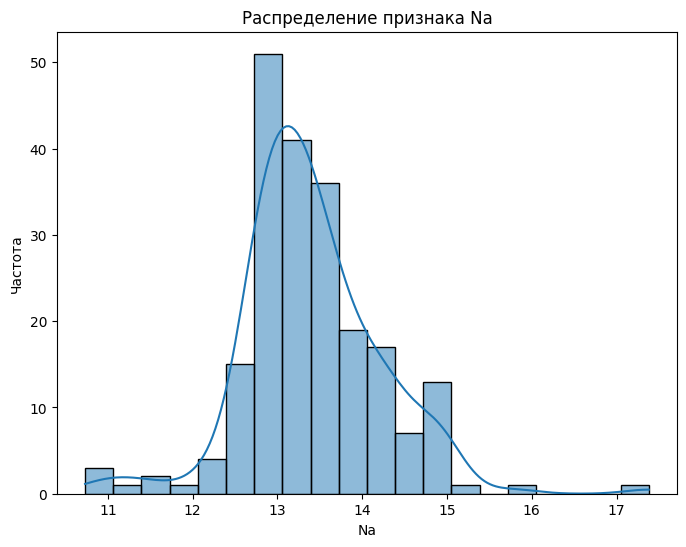

In [65]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Na'], bins=20, kde=True)
plt.title("Распределение признака Na")
plt.xlabel("Na")
plt.ylabel("Частота")
plt.show()

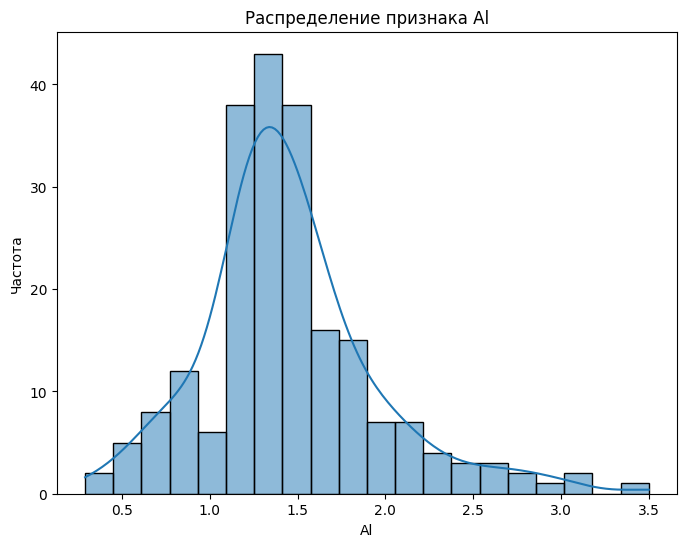

In [66]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Al'], bins=20, kde=True)
plt.title("Распределение признака Al")
plt.xlabel("Al")
plt.ylabel("Частота")
plt.show()

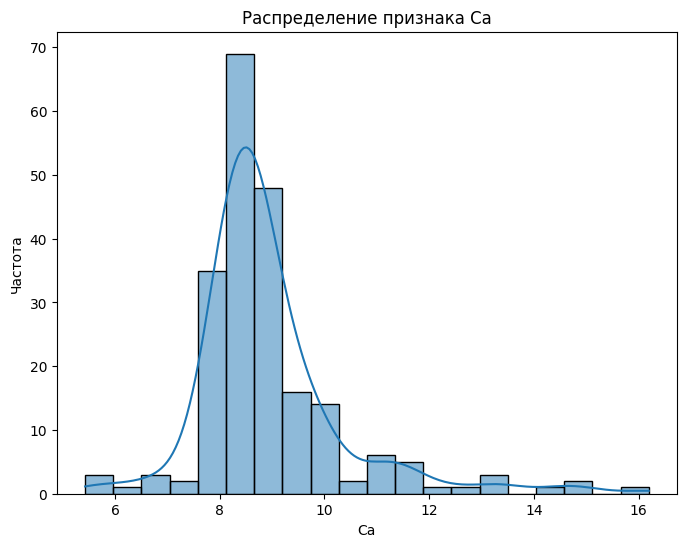

In [67]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Ca'], bins=20, kde=True)
plt.title("Распределение признака Ca")
plt.xlabel("Ca")
plt.ylabel("Частота")
plt.show()

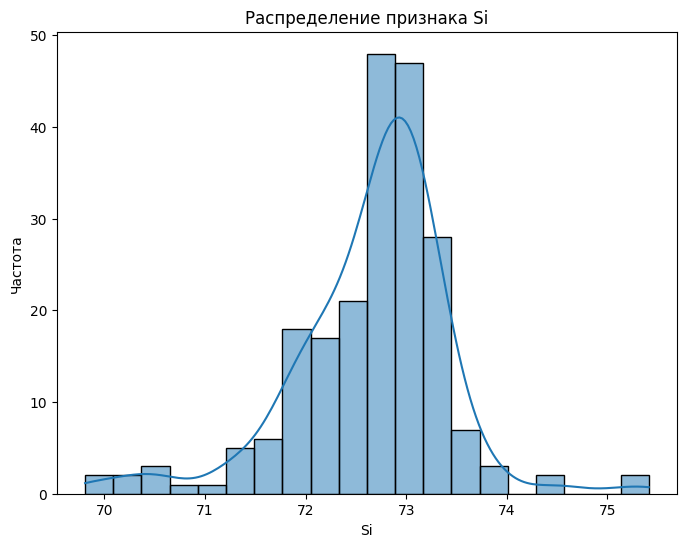

In [68]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Si'], bins=20, kde=True)
plt.title("Распределение признака Si")
plt.xlabel("Si")
plt.ylabel("Частота")
plt.show()

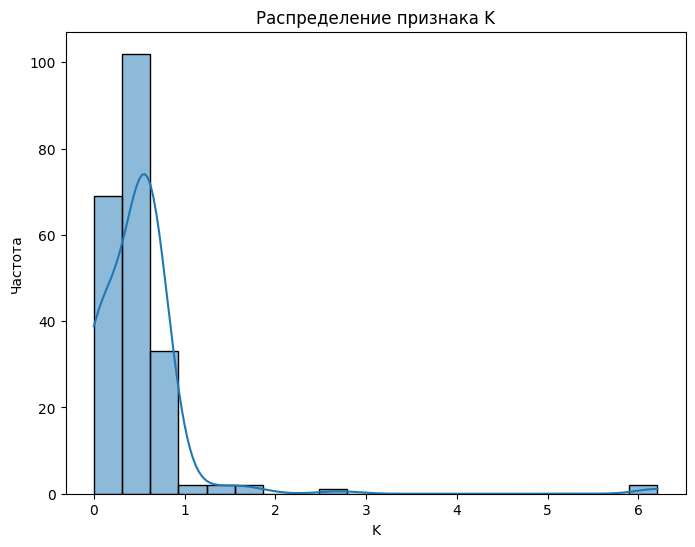

In [69]:
plt.figure(figsize=(8, 6))
sns.histplot(data['K'], bins=20, kde=True)
plt.title("Распределение признака K")
plt.xlabel("K")
plt.ylabel("Частота")
plt.show()

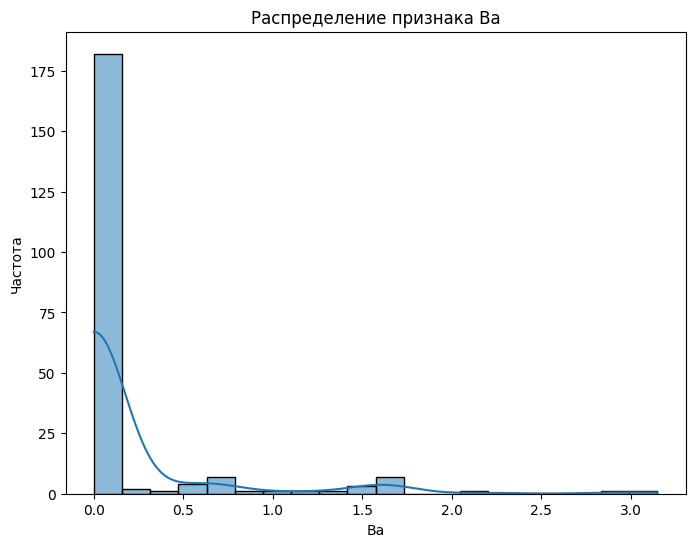

In [70]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Ba'], bins=20, kde=True)
plt.title("Распределение признака Ba")
plt.xlabel("Ba")
plt.ylabel("Частота")
plt.show()

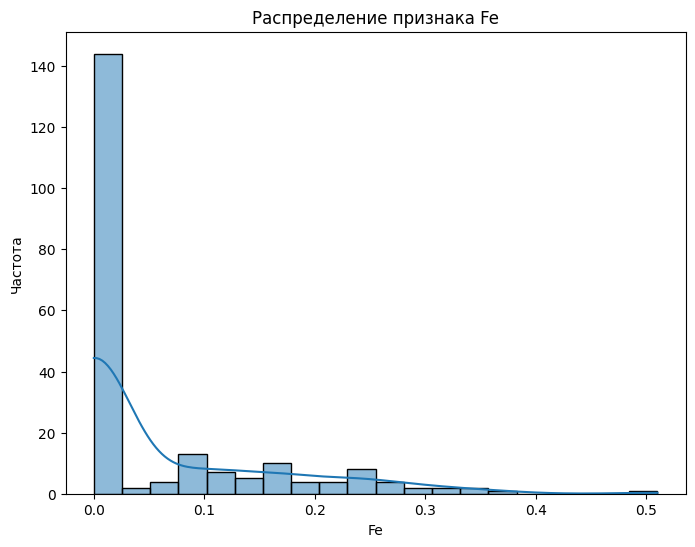

In [71]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Fe'], bins=20, kde=True)
plt.title("Распределение признака Fe")
plt.xlabel("Fe")
plt.ylabel("Частота")
plt.show()

#### (B) Исследуйте признаки на выбросы несколькими способами.

In [72]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
outliers_sum = outliers.sum()
print(outliers_sum)

RI      17
Na       7
Mg       0
Al      17
Si      12
K        7
Ca      27
Ba      38
Fe      12
Type    29
dtype: int64


Outlier
 1    192
-1     21
Name: count, dtype: int64


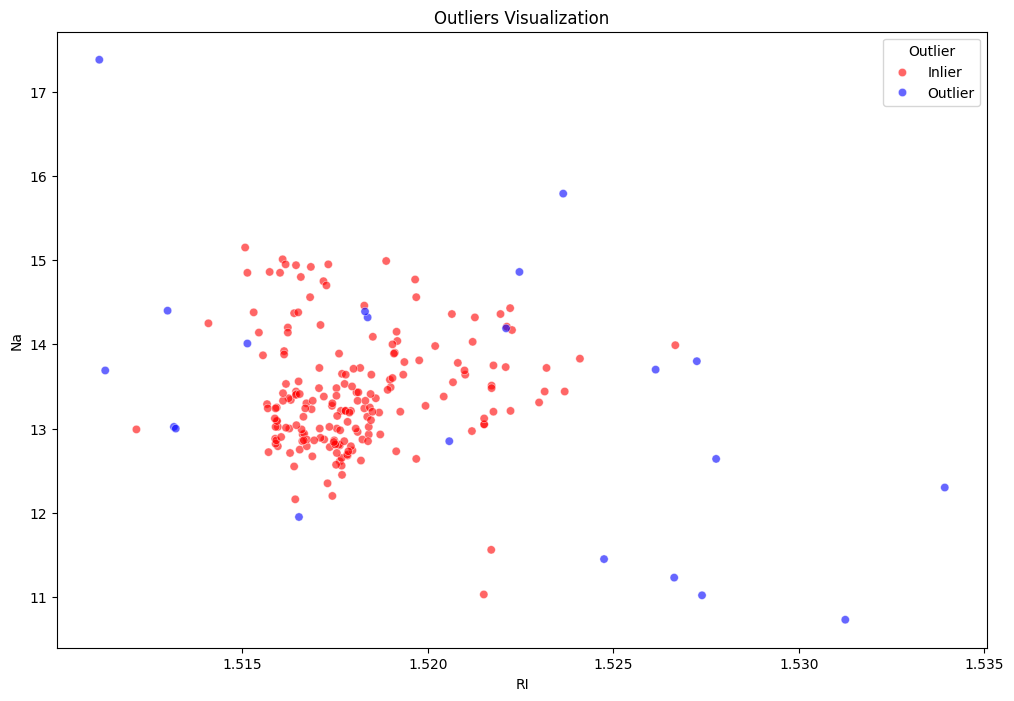

In [73]:
X = data.drop(columns=['Type'])
iso_forest = IsolationForest()
outliers = iso_forest.fit_predict(X)

data['Outlier'] = outliers

print(data['Outlier'].value_counts())

feature_x = 'RI'
feature_y = 'Na'

plt.figure(figsize=(12, 8))
sns.scatterplot(x=feature_x, y=feature_y, hue='Outlier', data=data, palette=['blue', 'red'], alpha=0.6)
plt.title('Outliers Visualization')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title='Outlier', loc='upper right', labels=['Inlier', 'Outlier'])
plt.show()

In [76]:
data.drop(columns=['Outlier'], inplace=True)

#### (C) Удалите выбросы. *Посчитайте процент удаленных записей от общего числа записей для каждого класса.

In [77]:
data_cleaned = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
percentage_removed = (len(data) - len(data_cleaned)) / len(data) * 100
print(f'Процент удаленных сэмплов: {percentage_removed}%')

data_cleaned['Type'].value_counts()

Процент удаленных сэмплов: 36.61971830985916%


Type
1    59
2    54
3    15
6     5
5     2
Name: count, dtype: int64

In [78]:
outliers = ((data_cleaned < (Q1 - 1.5 * IQR)) | (data_cleaned > (Q3 + 1.5 * IQR)))
outliers_sum = outliers.sum()
print(outliers_sum)

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64


### 7. Повторите п. 4, п. 5.

In [79]:
X_cleaned = data_cleaned.drop(columns=['Type'])
y_cleaned = data_cleaned['Type']

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [80]:
model_cleaned = RandomForestClassifier(random_state=42)
model_cleaned.fit(X_train_cleaned, y_train_cleaned)

y_pred_cleaned = model_cleaned.predict(X_test_cleaned)

accuracy_cleaned = accuracy_score(y_test_cleaned, y_pred_cleaned)
print(accuracy_cleaned)

0.7407407407407407


### 8. Сформулируйте выводы по проделанной работе.
#### (A) Кратко опишите, какие преобразования были сделаны с данными.

- Изучили распределения данных
- Разделили данные на трейн и тест выборки
- Обучили RF
- Удалили выбросы и посчитали процент удаленных записей
- Повторили обучение RF на очищенных данных

#### (B) Сравните точность двух моделей.

In [82]:
data = {
    'Model': ['With Outliers', 'Without Outliers'],
    'Accuracy': [rf_accuracy, accuracy_cleaned]
}

# Создание датафрейма
metrics_df = pd.DataFrame(data)

In [83]:
metrics_df

,Model,Accuracy
0,With Outliers,0.767442
1,Without Outliers,0.740741


#### (C) Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.

Исследовать данные на выбросы полезно, это позволяет нам определить дальнейшие шаги по разработке алгоритма, такие как выбор метода по обработке данных, выбору модели и т.п. Также обработка выбросов может повысить точность модели за счёт уменьшение шума. При этом удалять их стоит аккуратно, так как удаление чрезмерного количества данных может привести к потере нужной информации, а также ухудшению обобщающей способности. Например, как это было в работе выше, где после удаления выбросов *Accuracy* на тестовой выборке показал результат хуже.